Starting Bank: 5000
Ending Bank: 5177.205
Maximum: 5322.632
Minimum: 4779.265
Max Drawdown: 543.367
Annualized Standard Deviation: 2.488%
Sharpe Ratio: 0.537


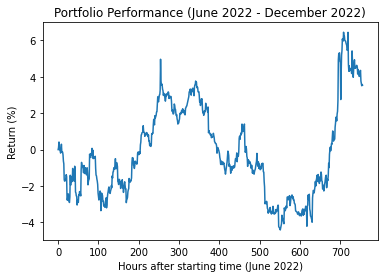

In [ ]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import numpy as np

def find_pairs():
    sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    sp500_list = np.array(sp500[0]['Symbol'])[0:]
    brkb = np.where(sp500_list == 'BRK.B')[0][0]
    sp500_list = np.delete(sp500_list, brkb, axis=0)
    bfb = np.where(sp500_list == 'BF.B')[0][0]
    sp500_list = np.delete(sp500_list, bfb, axis=0)
    pairs = []
    for i in range(len(sp500_list)):
        data = yf.Ticker(sp500_list[i]).history(period='100d', rounding=True)["Close"]
        df = pd.DataFrame(data)
        normalized_df=(df-df.mean())/df.std()
        for j in range(i+1, len(sp500_list)):
            data2 = yf.Ticker(sp500_list[j]).history(period='100d', rounding=True)["Close"]
            df2 = pd.DataFrame(data2)
            l = min(df.size, df2.size)
            normalized_df2=(df2-df2.mean())/df2.std()
            if l != 0:
                score, pvalue, _ = ts.coint(normalized_df[:l],normalized_df2[:l], maxlag=1)
                if pvalue < 0.2:
                    print((sp500_list[i], sp500_list[j], score, pvalue))
                    pairs.append((sp500_list[i], sp500_list[j], score, pvalue))
            n += 1
    return pairs

def getData(stock):
    intc = yf.Ticker(stock)
    data = intc.history(period = '1y', interval="60m")
    return data

def getLong(time, bank, pos):
    if pos[1]:
        return bank / amd['Close'][time]
    alpha = amd['Close'][:time].mean() / intc['Close'][:time].mean()
    intc_val = bank * (intc['Close'][time] * alpha) / (intc['Close'][time] * alpha + amd['Close'][time])
    intc_stock = intc_val / intc['Close'][time]
    return intc_stock

def getShort(time, bank, pos):
    if pos[0]:
        return bank / amd['Close'][time]
    alpha = amd['Close'][:time].mean() / intc['Close'][:time].mean()
    amd_val = bank * (amd['Close'][time]) / (intc['Close'][time] * alpha + amd['Close'][time])
    amd_stock = amd_val / amd['Close'][time]
    return amd_stock

def getZScore(time, bank):
    alpha = amd['Close'][:time].mean() / intc['Close'][:time].mean()
    intc_val = bank * (intc['Close'][time] * alpha) / (intc['Close'][time] * alpha + amd['Close'][time])
    amd_val = bank * (amd['Close'][time]) / (intc['Close'][time] * alpha + amd['Close'][time])
    intc_stock = intc_val / intc['Close'][time]
    amd_stock = amd_val / amd['Close'][time]
    epsilon = intc_val - gamma * amd_val
    diff = intc['Close'][:time] - amd['Close'][:time]
    mu = diff.mean()
    sigma = diff.std()
    z = (epsilon - mu) / sigma
    return z

def makeTrade(time, pos, stocks, bank):
    assets = bank + stocks[0] * intc['Close'][time] + stocks[1] * amd['Close'][time]
    series.append(assets)
    z = getZScore(time, bank)
    if z < -2.0 and not pos[0]:
        intc_stock = getLong(time, bank, pos)
        pos[0] = True
        stocks[0] = intc_stock
        bank = bank - intc['Close'][time] * intc_stock
    if z > 2.0 and not pos[1]:
        amd_stock= getShort(time, bank, pos)
        pos[1] = True
        stocks[1] = amd_stock
        bank = bank - amd['Close'][time] * amd_stock
    elif z < 0.75 and pos[1]:
        pos[1] = False
        bank = bank + amd['Close'][time] * stocks[1]
        stocks[1] = 0.0
    elif z > -0.5 and pos[0]:
        pos[0] = False
        bank = bank + intc['Close'][time] * stocks[0]
        stocks[0] = 0.0
    return assets, pos, stocks, bank

bank = 1000
longs = ['mmm', 'aapl', 'cosm', 'orcl', 'vz']
shorts = ['nvda', 'tsla', 'meta', 'vz', 'dis']
intc = getData('bac')
amd = getData('dis')
time = min(len(intc), len(amd)) // 2
gamma = 1.3
times = [i for i in range(756)]
totals = []
positions = [False, False]
stocks = [0.0, 0.0]
series = []
for i in range(len(longs)):
    bank = 1000
    positions = [False, False]
    stocks = [0.0, 0.0]
    intc = getData(longs[i])
    amd = getData(shorts[i])
    temp_totals = []
    for t in range(time, min(len(intc), len(amd))):
        tot, positions, stocks, bank = makeTrade(t, positions, stocks, bank)
        temp_totals.append(tot)
    if i == 0:
        totals = temp_totals
    else:
        totals = [totals[j] + temp_totals[j] for j in range(min(len(totals), len(temp_totals)))]
returns = [(t - 5000) / 50 for t in totals]
plt.plot(times, returns[:756])
plt.title('Portfolio Performance (June 2022 - December 2022)')
plt.xlabel('Hours after starting time (June 2022)')
plt.ylabel('Return (%)')
plt.show
print("Starting Bank:", 5000)
print("Ending Bank:", round(totals[-1], 3))
print("Maximum:", round(max(totals), 3))
print("Minimum:", round(min(totals), 3))
print("Max Drawdown:", round(max(totals) - min(totals), 3))
print("Annualized Standard Deviation:", str(round(np.std(totals) / 50, 3)) + str('%'))
print("Sharpe Ratio:", round(((totals[-1] - 5000) / 50 - 1.656) / (np.std(totals) / 50 * np.sqrt(2)), 3)) # 6 month bond rate at that time was 1.656%